In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [2]:
PATH = "data"
AUTOTUNE = tf.data.experimental.AUTOTUNE
WIDTH, HEIGHT = 128, 128
BATCH_SIZE = 4

In [3]:
def load_data(path):
    images = sorted(glob(f"{path}/images/*.png"))
    masks = sorted(glob(f"{path}/masks/*.png"))
    return images, masks

image_files, mask_files = load_data(PATH)

In [4]:
print(len(image_files), len(mask_files))
DATASET_SIZE = len(image_files)

2667 2667


In [5]:
dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

In [6]:
def parse_image(image_file, mask_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  #image = image/255.0
    
    
  mask = tf.io.read_file(mask_file)
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.convert_image_dtype(mask, tf.uint8)
  mask = tf.image.resize(mask, [128, 128])
  #mask -= 1

  return image, mask

In [7]:
dataset = dataset.map(parse_image).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.79595786, 0.7920363 , 0.78419316],
        [0.8033031 , 0.7989335 , 0.7905791 ],
        [0.8060107 , 0.8024511 , 0.794246  ],
        ...,
        [0.8470589 , 0.8470589 , 0.8470589 ],
        [0.85098046, 0.8431373 , 0.8470589 ],
        [0.85098046, 0.8431373 , 0.8470589 ]],

       [[0.7996018 , 0.7956802 , 0.7878371 ],
        [0.83088243, 0.8230393 , 0.82696086],
        [0.83872557, 0.834804  , 0.82696086],
        ...,
        [0.8479033 , 0.8479033 , 0.8479033 ],
        [0.8484222 , 0.8405791 , 0.84450066],
        [0.8488205 , 0.8409774 , 0.84489894]],

       [[0.7538144 , 0.74989283, 0.74204963],
        [0.8484222 , 0.8405791 , 0.84450066],
        [0.8705883 , 0.86274517, 0.86666673],
        ...,
        [0.8519455 , 0.8519455 , 0.8519455 ],
        [0.8470589 , 0.8470589 , 0.8470589 ],
        [0.8470589 , 0.83921576, 0.8431373 ]],

       ...,

       [[0.11156558, 0.10372244, 0.10764401],
        [0.1

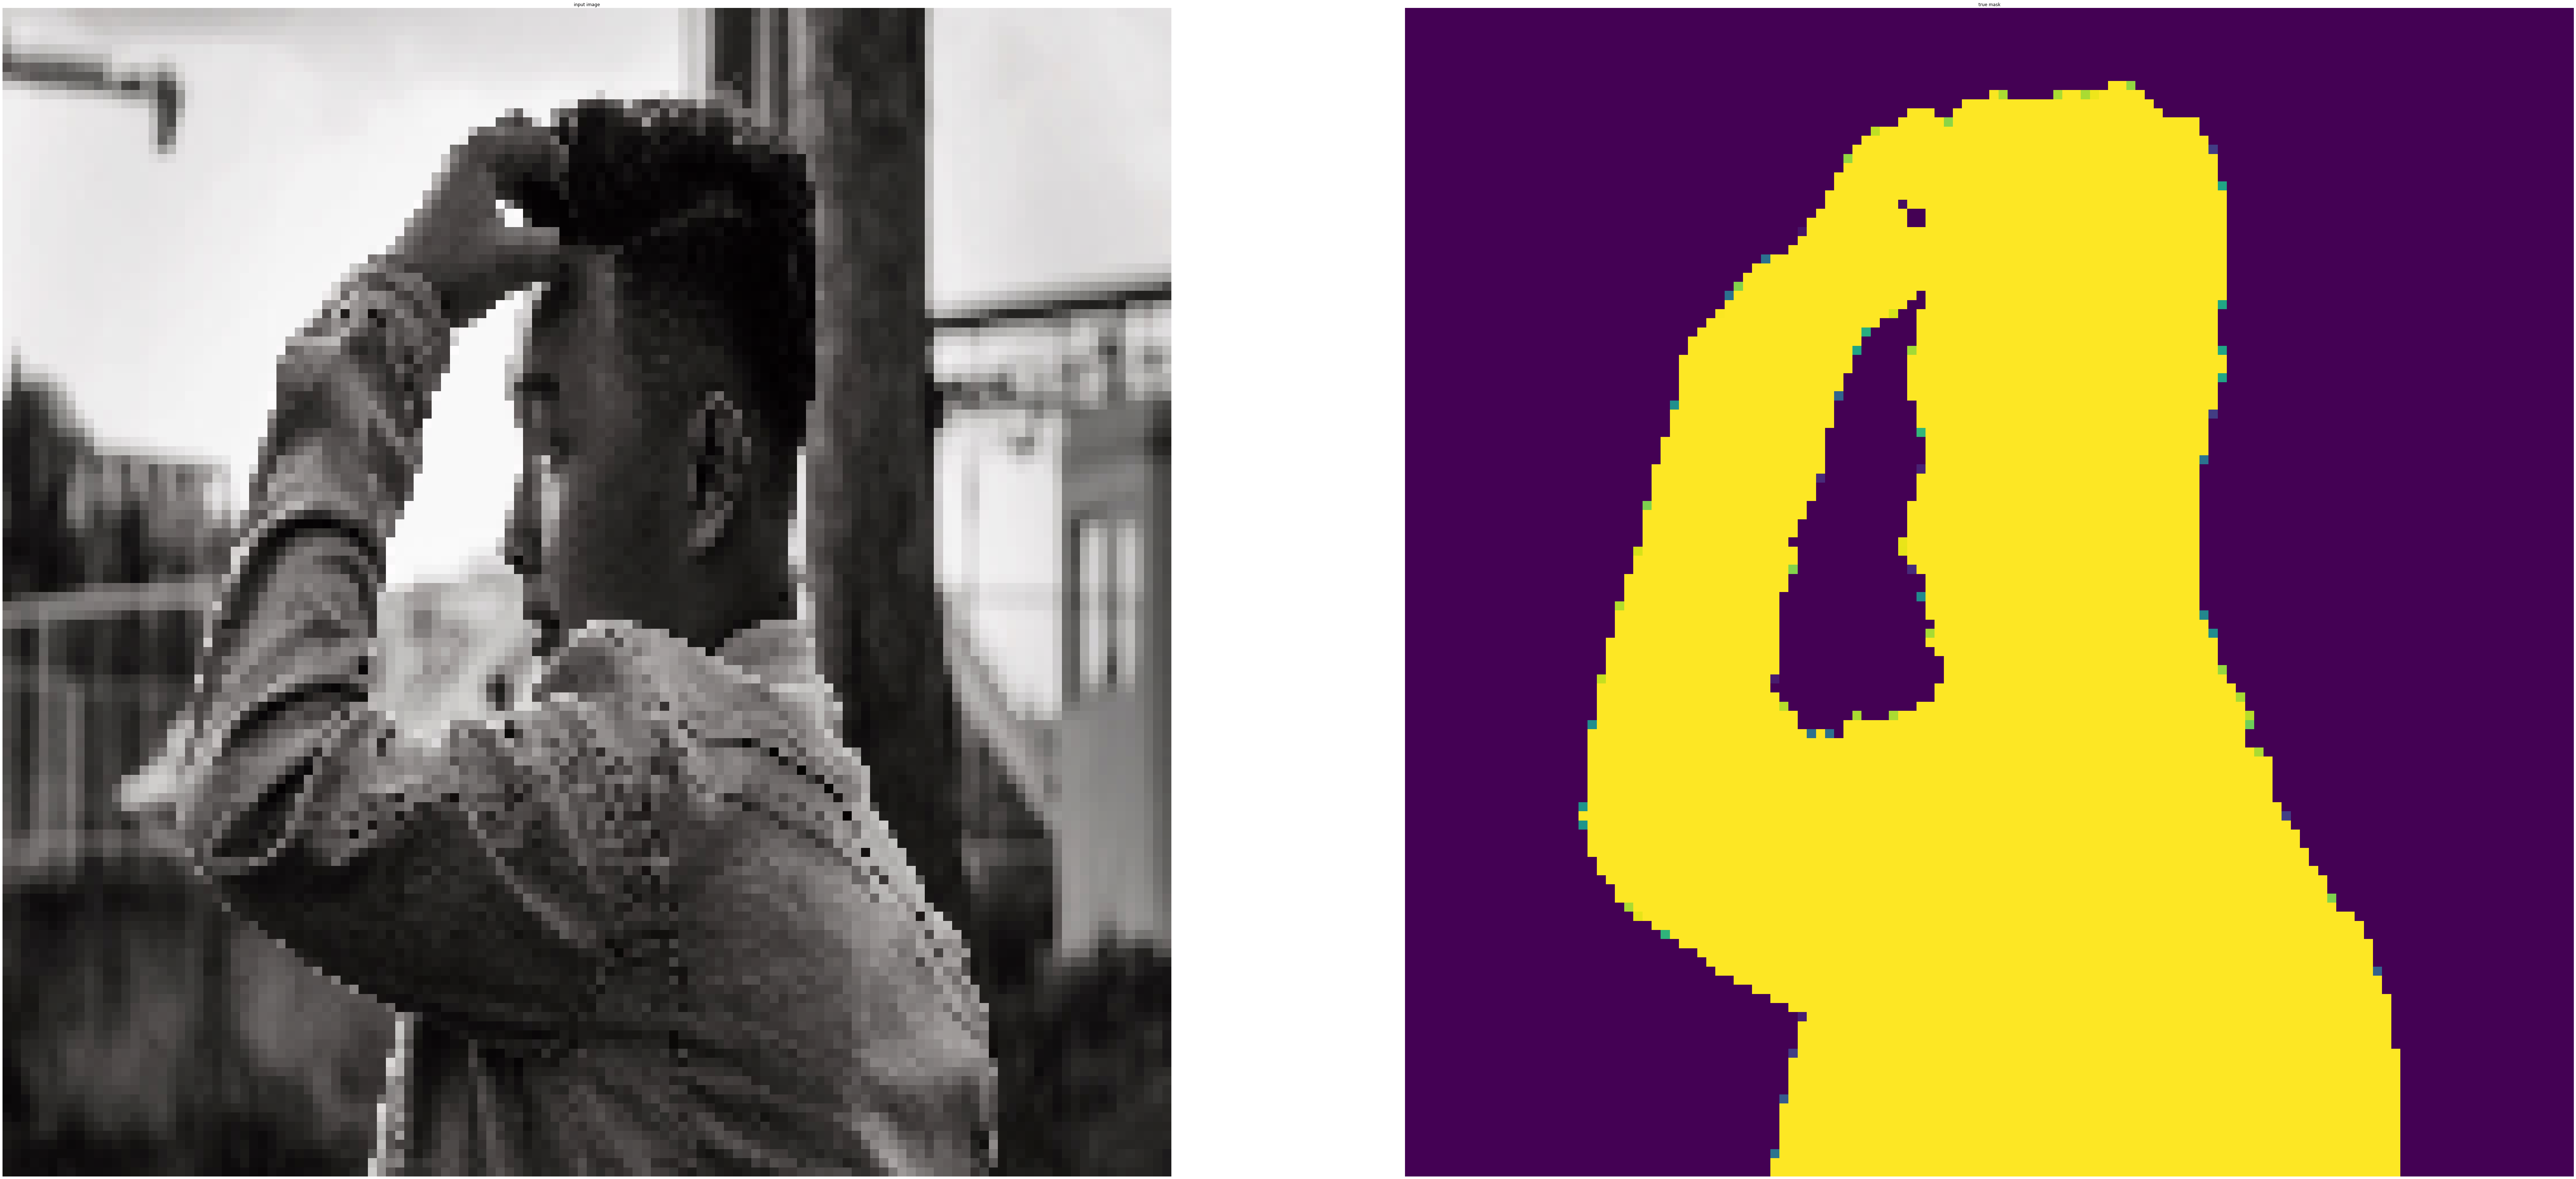

In [8]:
def display(display_list):
    plt.figure(figsize=(128,128))
    print(display_list)
    title = ['input image', 'true mask', 'predicted mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in dataset.take(2):
    sample_image, sample_mask = image, mask
    
display([sample_image[1], sample_mask[1]])

In [9]:
print(dataset)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [12]:
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'    
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [13]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [14]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    skips = down_stack(inputs)
    #print(skips)

    x = skips[-1]
    #print(x)

    skips = reversed(skips[:-1])
    print(skips)

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding='same')

    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)


In [15]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy,
              metrics=['accuracy'])

In [16]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=2):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[1.3970589e-02, 9.4852954e-02, 2.6513481e-01],
        [2.3529414e-02, 9.8039225e-02, 2.6274511e-01],
        [2.3529414e-02, 9.4362751e-02, 2.7677697e-01],
        ...,
        [0.0000000e+00, 2.3250616e-01, 4.5413607e-01],
        [2.5428925e-03, 2.2215076e-01, 4.4641548e-01],
        [3.6458336e-03, 2.1773899e-01, 4.2870712e-01]],

       [[2.3529414e-02, 9.7303927e-02, 2.6758578e-01],
        [1.6666668e-02, 9.9540457e-02, 2.6516545e-01],
        [1.9822305e-02, 9.1390938e-02, 2.7450985e-01],
        ...,
        [2.1446080e-04, 2.3109683e-01, 4.5750615e-01],
        [3.9215689e-03, 2.2352943e-01, 4.4705886e-01],
        [2.1752450e-03, 2.2251840e-01, 4.4457722e-01]],

       [[1.1764707e-02, 9.4117656e-02, 2.7745098e-01],
        [2.3529414e-02, 9.8039225e-02, 2.6617649e-01],
        [1.5686275e-02, 9.8008588e-02, 2.8241423e-01],
        ...,
        [4.5955885e-04, 2.3504904e-01, 4.7080272e-01],
        [4.9019611e-0

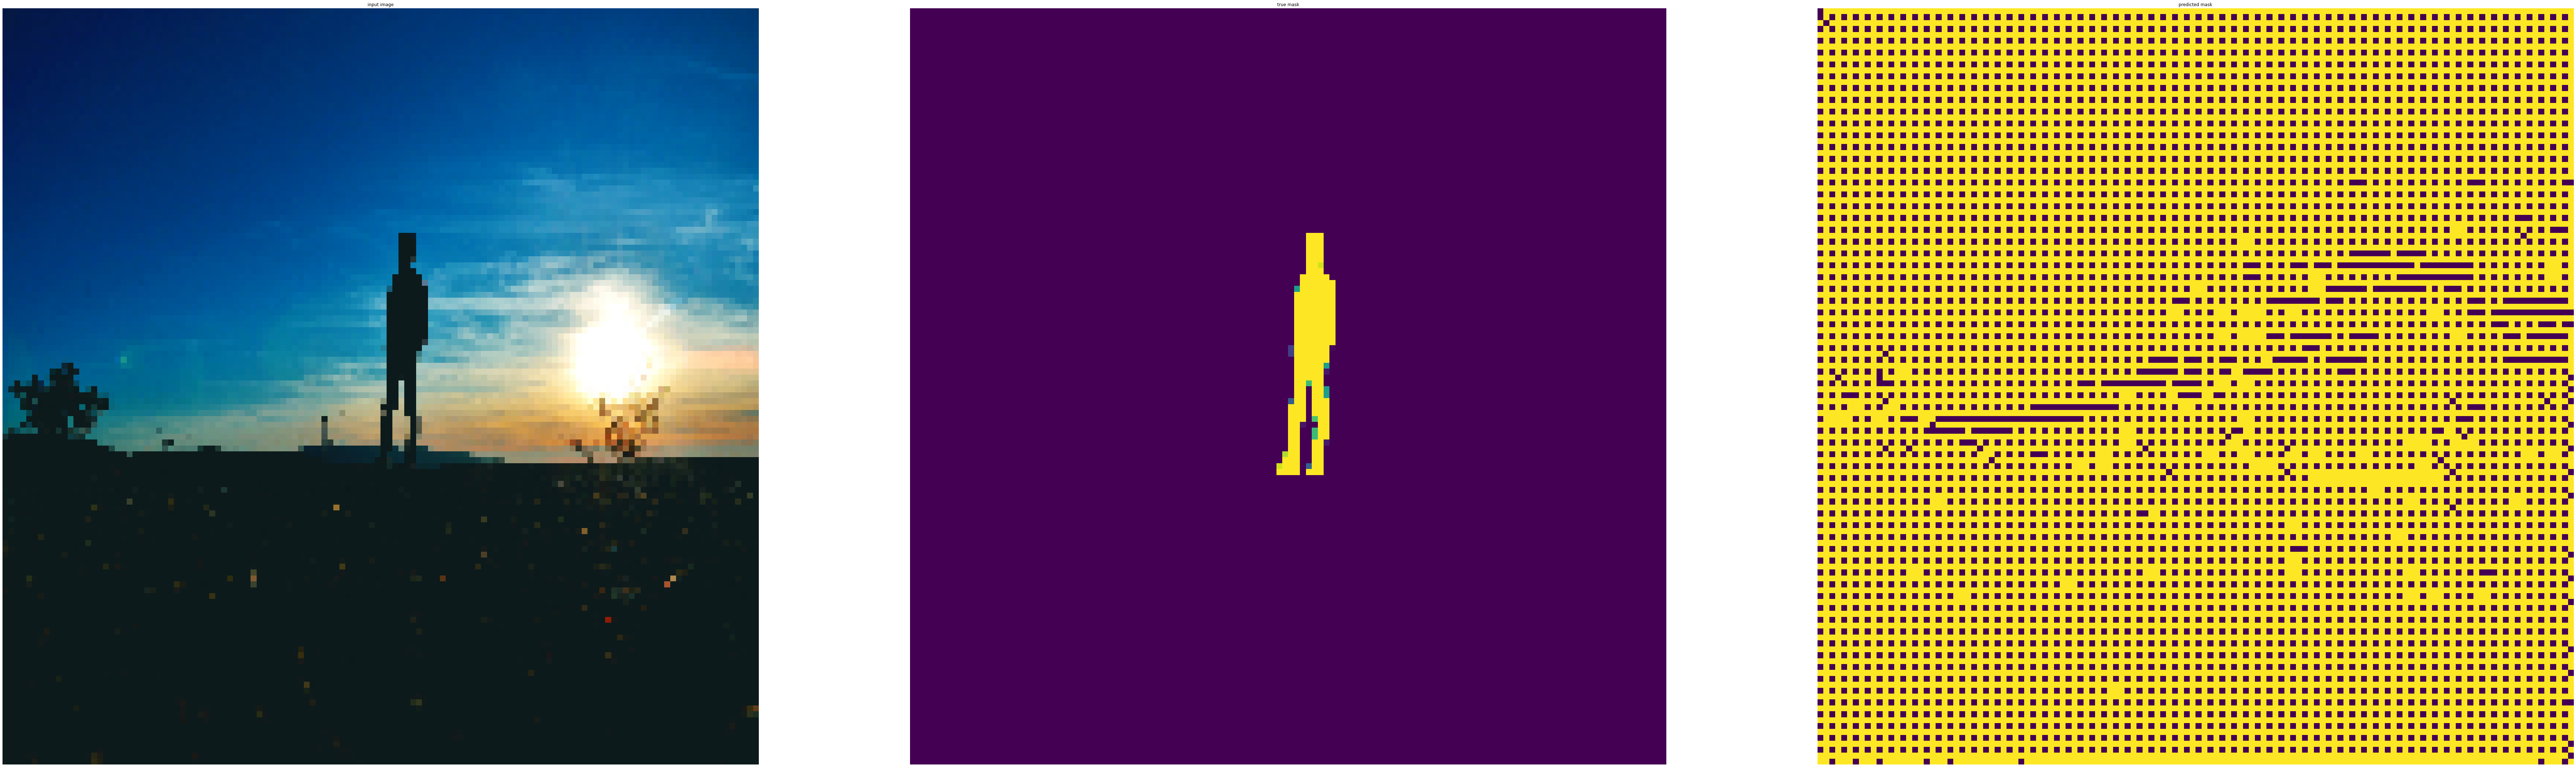

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.31520373, 0.26724496, 0.23048025],
        [0.12802926, 0.0613626 , 0.03023131],
        [0.11218981, 0.06264552, 0.0415671 ],
        ...,
        [0.22923562, 0.1928692 , 0.15757507],
        [0.10520834, 0.15162379, 0.10000001],
        [0.10626533, 0.14316407, 0.09863665]],

       [[0.28184745, 0.26861215, 0.21027881],
        [0.3740005 , 0.3493375 , 0.27874926],
        [0.15513557, 0.09765243, 0.07020144],
        ...,
        [0.22913988, 0.20547643, 0.15855163],
        [0.10290289, 0.15595512, 0.09874771],
        [0.08105087, 0.11980317, 0.07342219]],

       [[0.3937079 , 0.3818628 , 0.3184666 ],
        [0.366682  , 0.3389974 , 0.2887408 ],
        [0.2570734 , 0.20515473, 0.17472045],
        ...,
        [0.18172489, 0.17748928, 0.12922412],
        [0.10762868, 0.15412456, 0.09922259],
        [0.08931526, 0.12531404, 0.08075981]],

       ...,

       [[0.09736521, 0.05728784, 0.04432828],
        [0.0

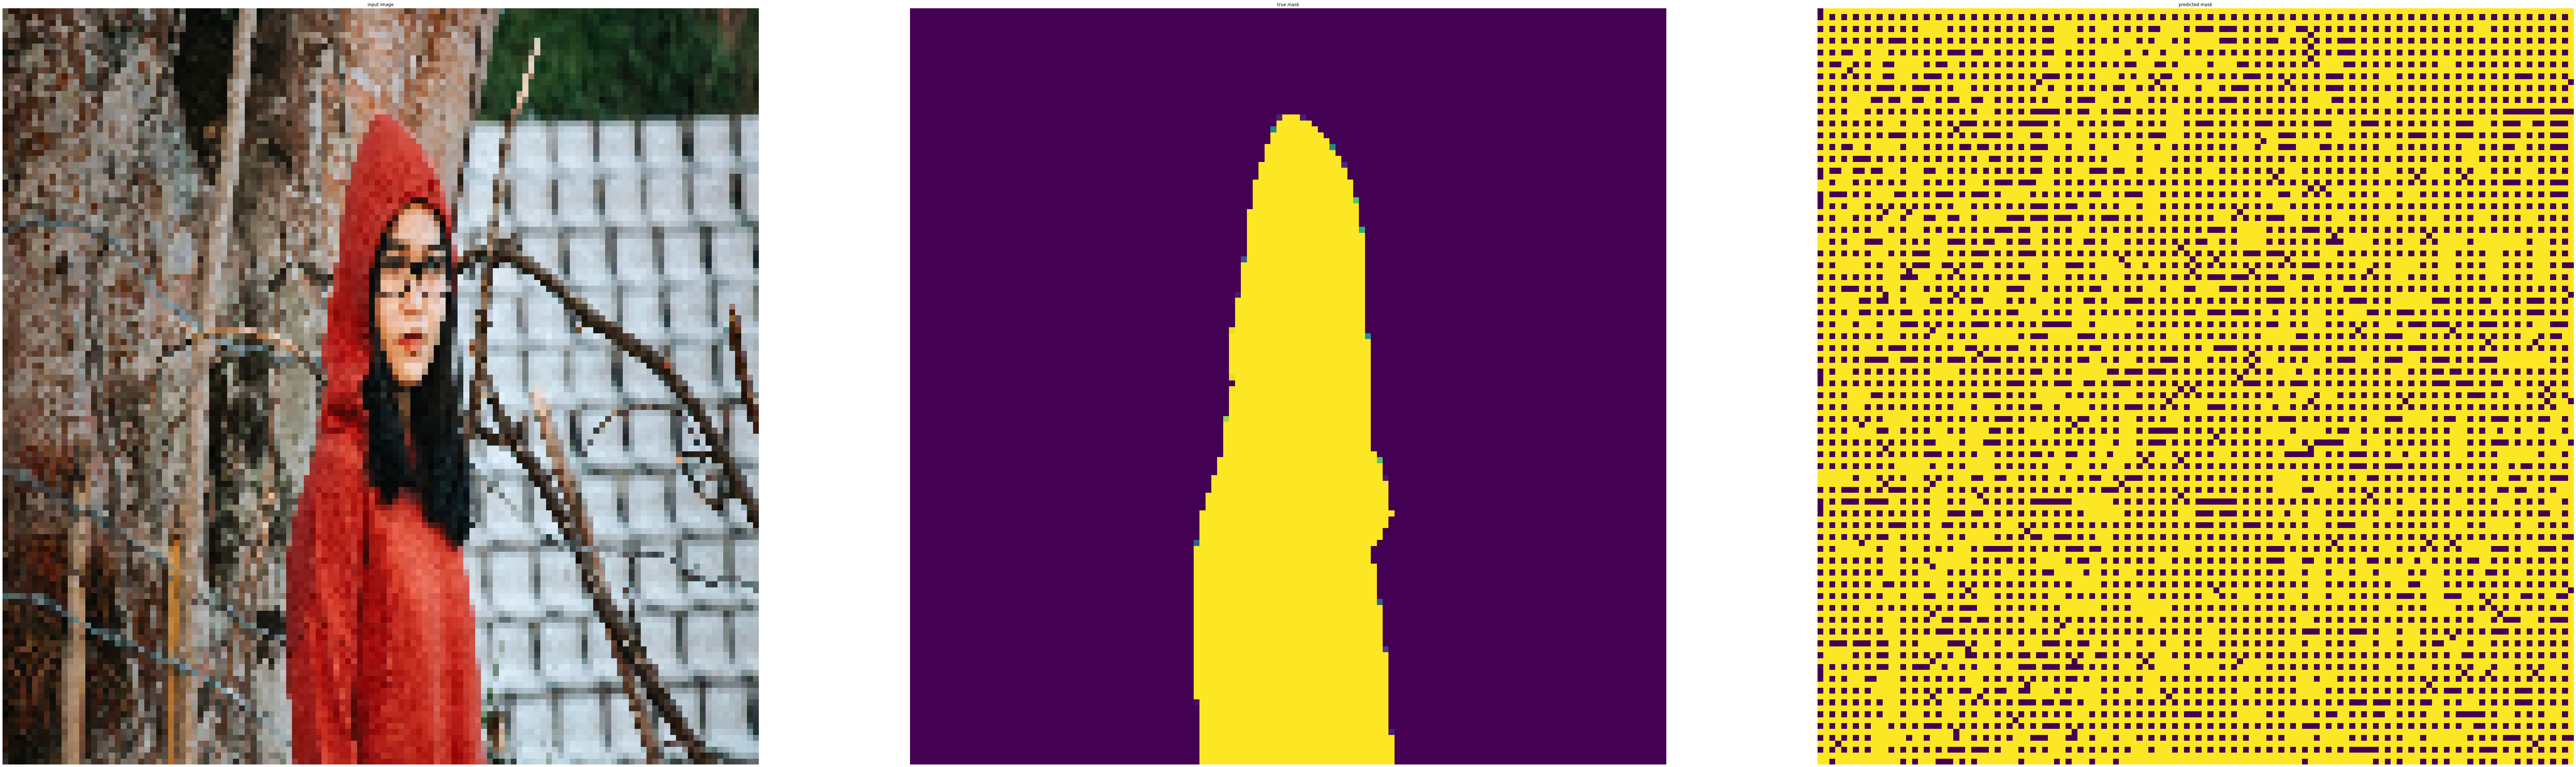

In [17]:
show_predictions(dataset)

In [18]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

print(train_size, val_size, test_size)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
validation_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

print(train_ds, test_ds, validation_ds)

2133 266 266
<TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)> <TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)> <SkipDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(dataset)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [20]:
print(train_ds)
print(test_ds)

<TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [21]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = train_size//BATCH_SIZE

#model_history = model.fit(train_ds, epochs=EPOCHS,
#                          steps_per_epoch=STEPS_PER_EPOCH,
#                          validation_steps=VALIDATION_STEPS,
#                          validation_data=test_ds,
#                          callbacks=[DisplayCallback()])

model_history = model.fit(train_ds, epochs=EPOCHS,
                          validation_data=test_ds,
                          callbacks=[DisplayCallback()])

Epoch 1/10


TypeError: in user code:

    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:796 train_step
        loss = self.compiled_loss(
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:755 __init__  **
        super(SparseCategoricalCrossentropy, self).__init__(
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:241 __init__
        super(LossFunctionWrapper, self).__init__(reduction=reduction, name=name)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:102 __init__
        losses_utils.ReductionV2.validate(reduction)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/keras/utils/losses_utils.py:76 validate
        if key not in cls.all():
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1800 tensor_equals
        self, other = maybe_promote_tensors(self, other)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1202 maybe_promote_tensors
        ops.convert_to_tensor(tensor, dtype, name="x"))
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1566 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py:264 constant
        return _constant_impl(value, dtype, shape, name, verify_shape=False,
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py:281 _constant_impl
        tensor_util.make_tensor_proto(
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/framework/tensor_util.py:457 make_tensor_proto
        _AssertCompatible(values, dtype)
    /Users/chaturawijetunga/work/tools/miniforge3/envs/tfp39/lib/python3.9/site-packages/tensorflow/python/framework/tensor_util.py:336 _AssertCompatible
        raise TypeError("Expected %s, got %s of type '%s' instead." %

    TypeError: Expected float32, got 'auto' of type 'str' instead.
